<a href="https://colab.research.google.com/github/balcomes/keras-autoencoders/blob/master/train_conv_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs

		# loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)

		# build the encoder model
		encoder = Model(inputs, latent, name="encoder")

		# start building the decoder model which will accept the
		# output of the encoder as its inputs
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)

		# build the decoder model
		decoder = Model(latentInputs, outputs, name="decoder")

		# our autoencoder is the encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)),
			name="autoencoder")

		# return a 3-tuple of the encoder, decoder, and autoencoder
		return (encoder, decoder, autoencoder)

In [2]:
# USAGE
# python train_conv_autoencoder.py

# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
#from pyimagesearch.convautoencoder import ConvAutoencoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-s", "--samples", type=int, default=8,
#	help="# number of samples to visualize when decoding")
#ap.add_argument("-o", "--output", type=str, default="output.png",
#	help="path to output visualization file")
#ap.add_argument("-p", "--plot", type=str, default="plot.png",
#	help="path to output plot file")
#args = vars(ap.parse_args())

# initialize the number of epochs to train for and batch size
EPOCHS = 1
BS = 32

# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()

# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder.fit(
	trainX, trainX,
	validation_data=(testX, testX),
	epochs=EPOCHS,
	batch_size=BS)

# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])

# use the convolutional autoencoder to make predictions on the
# testing images, then initialize our list of output images
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
outputs = None

# loop over our number of output samples
#for i in range(0, args["samples"]):
	# grab the original image and reconstructed image
#	original = (testX[i] * 255).astype("uint8")
#	recon = (decoded[i] * 255).astype("uint8")

	# stack the original and reconstructed image side-by-side
	#output = np.hstack([original, recon])

	# if the outputs array is empty, initialize it as the current
	# side-by-side image display
	#if outputs is None:
	#	outputs = output

	# otherwise, vertically stack the outputs
	#else:
	#	outputs = np.vstack([outputs, output])

# save the outputs image to disk
#cv2.imwrite(args["output"], outputs)

[INFO] loading MNIST dataset...
[INFO] building autoencoder...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 199s 3ms/sample - loss: 0.0185 - val_loss: 0.0106
[INFO] making predictions...


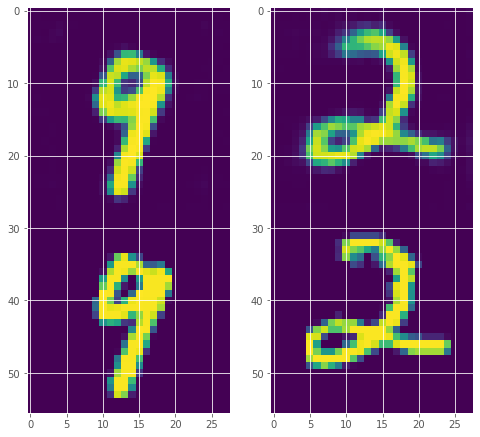

In [3]:
%matplotlib inline
import numpy as np

fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 1
for i in range(1, columns*rows + 1):
    k = np.random.randint(0,10000)
    img = np.vstack([decoded[k,:,:,0], testX[k,:,:,0]])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

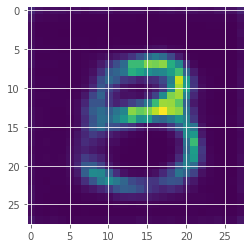

In [4]:
plt.imshow(autoencoder.predict(np.asarray(np.random.random(28*28).reshape([1,28,28,1])))[0,:,:,0])

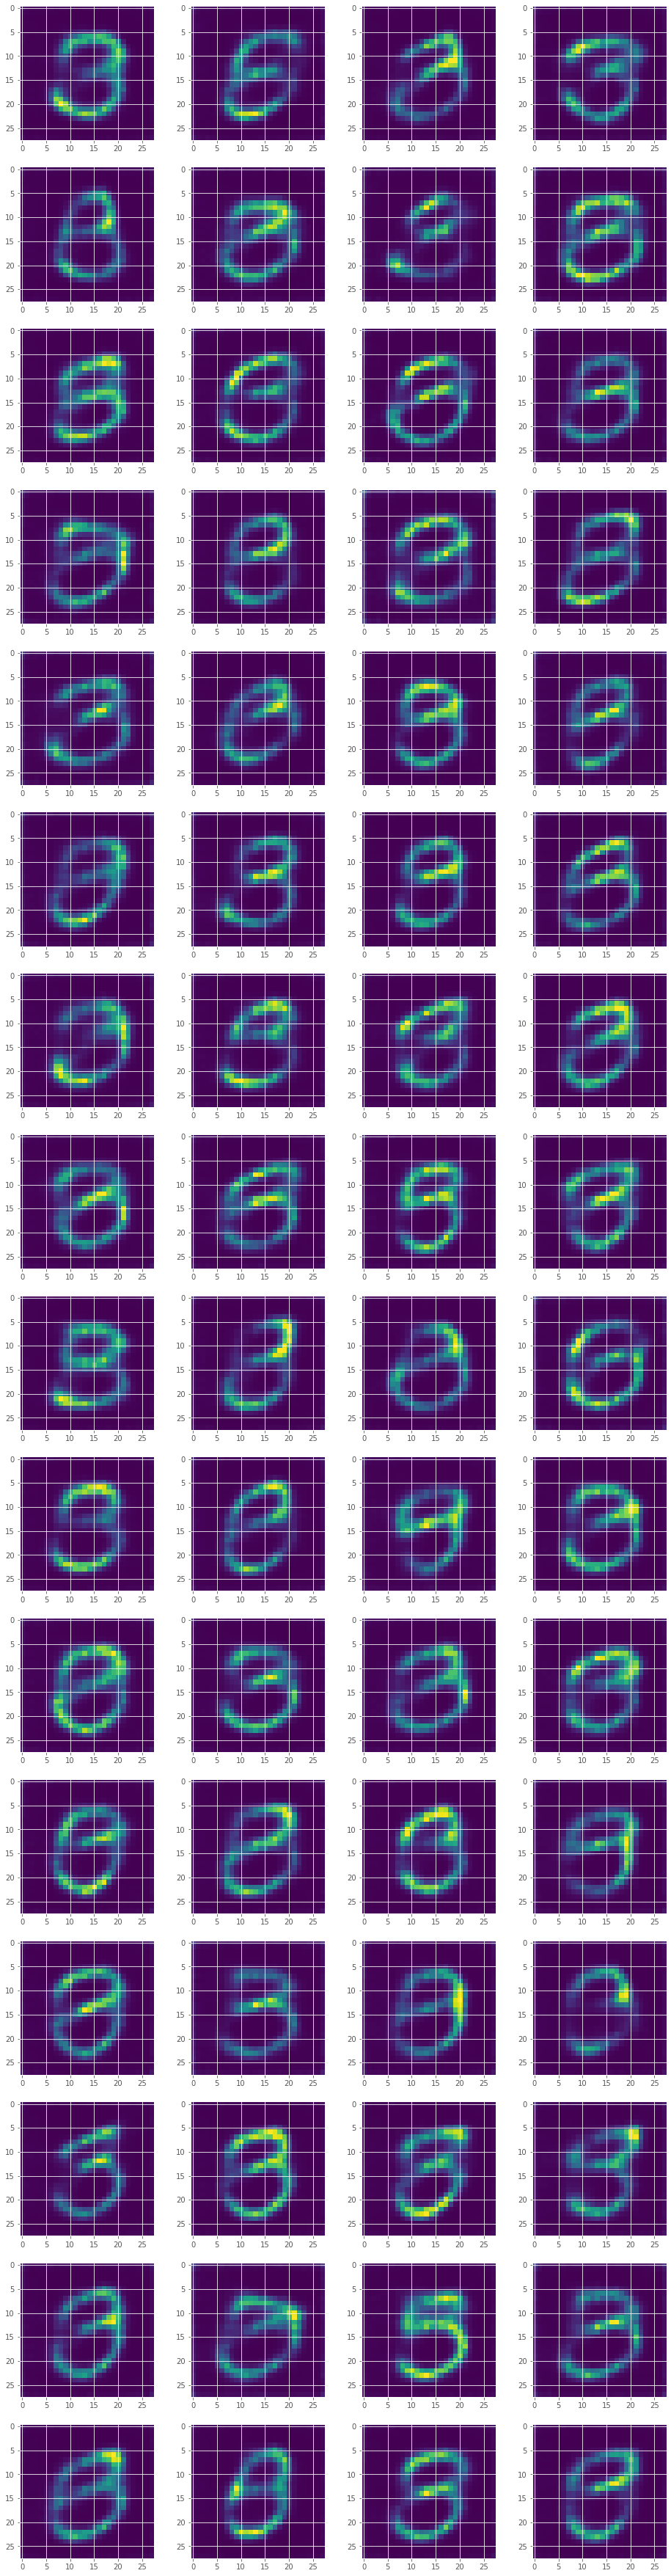

In [5]:
fig=plt.figure(figsize=(16, 64))
columns = 4
rows = 16
for i in range(1, columns*rows + 1):
    img = autoencoder.predict(np.asarray(np.random.random(28*28).reshape([1,28,28,1])))[0,:,:,0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [0]:
#!tf_upgrade_v2 \
#  --intree my_project/ \
#  --outtree my_project_v2/ \
#  --reportfile report.txt

In [0]:
import imageio

In [0]:
dwarves = imageio.imread('dwarves.png')

In [9]:
dwarves.shape

(352, 192, 3)

In [0]:
tiles = np.expand_dims(dwarves, axis=-1)
tiles = tiles.astype("float32") / 255.0
tiles_r = tiles[:,:, 0, :]
tiles_g = tiles[:,:, 1, :]
tiles_b = tiles[:,:, 2, :]

In [0]:
M = 16
N = 16

tiles_r = np.asarray(tiles_r)
tiles_g = np.asarray(tiles_g)
tiles_b = np.asarray(tiles_b)


tiles_r = [tiles_r[x:x+M,y:y+N] for x in range(0,tiles_r.shape[0],M) for y in range(0,tiles_r.shape[1],N)]
tiles_g = [tiles_g[x:x+M,y:y+N] for x in range(0,tiles_g.shape[0],M) for y in range(0,tiles_g.shape[1],N)]
tiles_b = [tiles_b[x:x+M,y:y+N] for x in range(0,tiles_b.shape[0],M) for y in range(0,tiles_b.shape[1],N)]

tiles_r = np.asarray(tiles_r)
tiles_g = np.asarray(tiles_g)
tiles_b = np.asarray(tiles_b)

tiles_r = tiles_r[[np.var(x) != 0 for x in tiles_r]]
tiles_g = tiles_g[[np.var(x) != 0 for x in tiles_g]]
tiles_b = tiles_b[[np.var(x) != 0 for x in tiles_b]]

In [12]:
tiles_r.shape

(227, 16, 16, 1)

([], <a list of 0 Text yticklabel objects>)

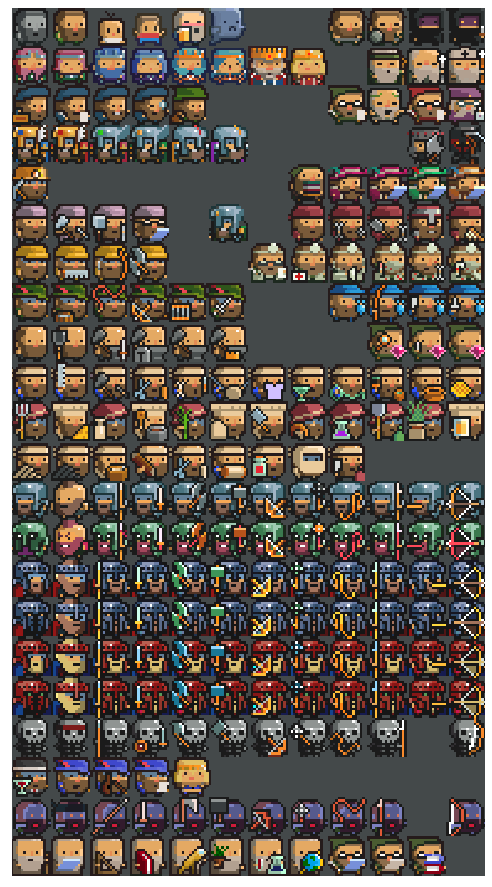

In [13]:
plt.figure(figsize=(16, 16))
plt.imshow(dwarves)
plt.xticks([])
plt.yticks([])

In [0]:
trainX = tiles_r

In [15]:
EPOCHS = 25
BS = 32

# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(16, 16, 1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder.fit(
	trainX, trainX,
	epochs=EPOCHS,
	batch_size=BS)

[INFO] building autoencoder...
Train on 227 samples
Epoch 1/25
227/227 [==============================] - 1s 5ms/sample - loss: 0.1099
Epoch 2/25
227/227 [==============================] - 0s 1ms/sample - loss: 0.0626
Epoch 3/25
227/227 [==============================] - 0s 1ms/sample - loss: 0.0527
Epoch 4/25
227/227 [==============================] - 0s 1ms/sample - loss: 0.0467
Epoch 5/25
227/227 [==============================] - 0s 1ms/sample - loss: 0.0420
Epoch 6/25
227/227 [==============================] - 0s 1ms/sample - loss: 0.0388
Epoch 7/25
227/227 [==============================] - 0s 1ms/sample - loss: 0.0354
Epoch 8/25
227/227 [==============================] - 0s 1ms/sample - loss: 0.0327
Epoch 9/25
227/227 [==============================] - 0s 1ms/sample - loss: 0.0313
Epoch 10/25
227/227 [==============================] - 0s 1ms/sample - loss: 0.0295
Epoch 11/25
227/227 [==============================] - 0s 1ms/sample - loss: 0.0277
Epoch 12/25
227/227 [============

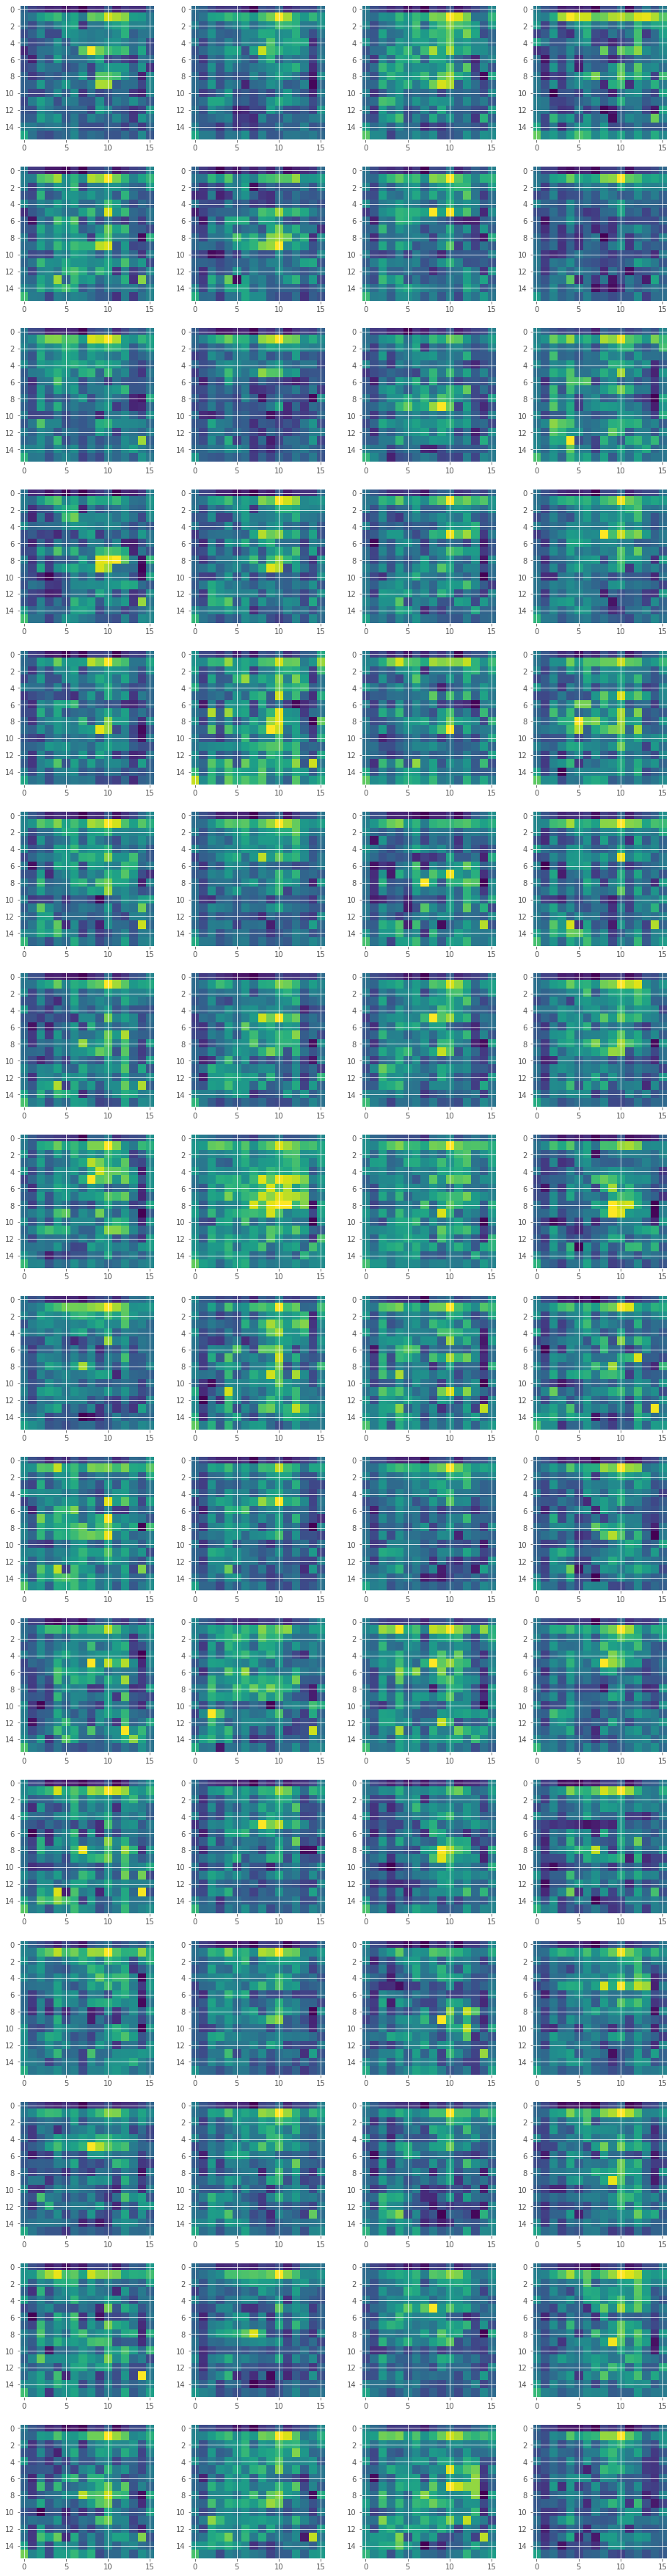

In [16]:
fig=plt.figure(figsize=(16, 64))
columns = 4
rows = 16
for i in range(1, columns*rows + 1):
    img = autoencoder.predict(np.asarray(np.random.random(16*16).reshape([1,16,16,1])))[0,:,:,0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [0]:
def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb

def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i+lv//3], 16) for i in range(0, lv, lv//3))

In [18]:
hex_to_rgb(rgb_to_hex((255, 255, 195)))

(255, 255, 195)

In [19]:
from ast import literal_eval 
  
hex = rgb_to_hex((255, 255, 195))
print(hex)
literal_eval("0x" + str(hex))

ffffc3


16777155

In [20]:
trainX.shape

(227, 16, 16, 1)

In [21]:
tiles.shape

(352, 192, 3, 1)

In [0]:
trainX_r = tiles_r
trainX_g = tiles_g
trainX_b = tiles_b

In [23]:
EPOCHS = 25
BS = 8



# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder_r, decoder_r, autoencoder_r) = ConvAutoencoder.build(16, 16, 1)
opt = Adam(lr=1e-3)
autoencoder_r.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder_r.fit(
	trainX_r, trainX_r,
	epochs=EPOCHS,
	batch_size=BS)




# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder_g, decoder_g, autoencoder_g) = ConvAutoencoder.build(16, 16, 1)
opt = Adam(lr=1e-3)
autoencoder_g.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder_g.fit(
	trainX_g, trainX_g,
	epochs=EPOCHS,
	batch_size=BS)




# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder_b, decoder_b, autoencoder_b) = ConvAutoencoder.build(16, 16, 1)
opt = Adam(lr=1e-3)
autoencoder_b.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder_b.fit(
	trainX_b, trainX_b,
	epochs=EPOCHS,
	batch_size=BS)




[INFO] building autoencoder...
Train on 227 samples
Epoch 1/25
227/227 [==============================] - 2s 7ms/sample - loss: 0.0792
Epoch 2/25
227/227 [==============================] - 0s 2ms/sample - loss: 0.0499
Epoch 3/25
227/227 [==============================] - 0s 2ms/sample - loss: 0.0407
Epoch 4/25
227/227 [==============================] - 0s 2ms/sample - loss: 0.0345
Epoch 5/25
227/227 [==============================] - 0s 2ms/sample - loss: 0.0311
Epoch 6/25
227/227 [==============================] - 0s 2ms/sample - loss: 0.0273
Epoch 7/25
227/227 [==============================] - 0s 2ms/sample - loss: 0.0255
Epoch 8/25
227/227 [==============================] - 0s 2ms/sample - loss: 0.0233
Epoch 9/25
227/227 [==============================] - 0s 2ms/sample - loss: 0.0219
Epoch 10/25
227/227 [==============================] - 0s 2ms/sample - loss: 0.0202
Epoch 11/25
227/227 [==============================] - 0s 2ms/sample - loss: 0.0188
Epoch 12/25
227/227 [============

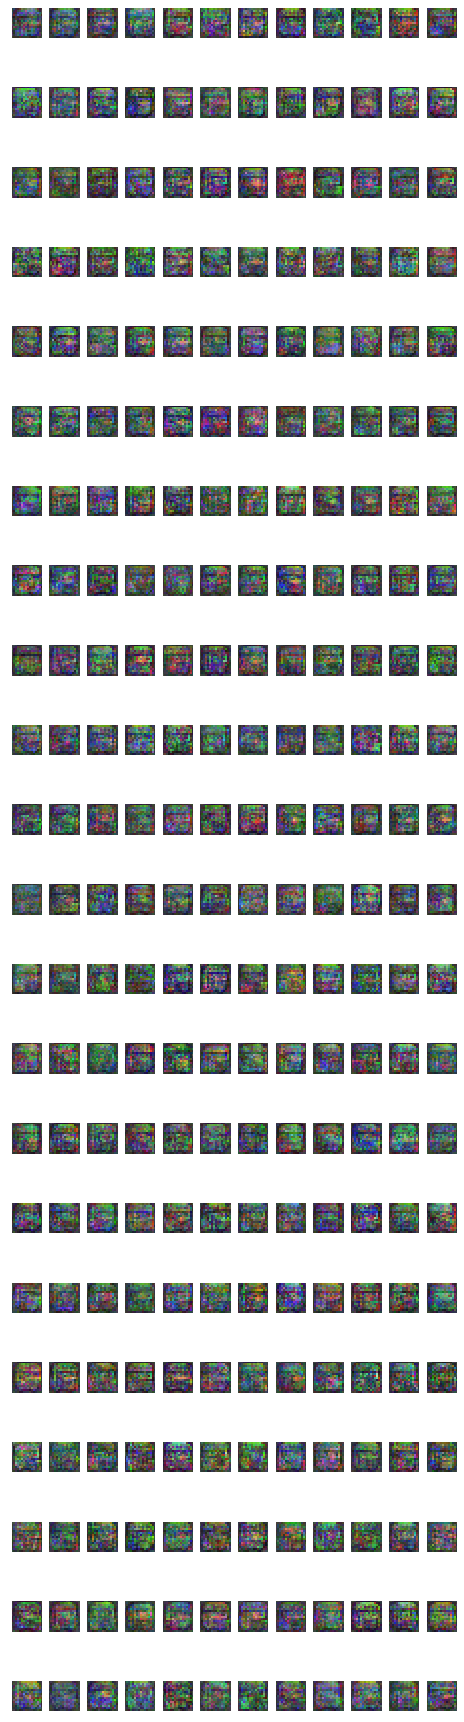

In [24]:
fig=plt.figure(figsize=(8, 32))
columns = 12
rows = 22
for i in range(1, columns*rows + 1):
    img_r = autoencoder_r.predict(np.asarray(np.random.random(16*16).reshape([1,16,16,1])))[0,:,:,0]
    img_g = autoencoder_g.predict(np.asarray(np.random.random(16*16).reshape([1,16,16,1])))[0,:,:,0]
    img_b = autoencoder_b.predict(np.asarray(np.random.random(16*16).reshape([1,16,16,1])))[0,:,:,0]
    img_rgb = np.dstack((img_r,img_g,img_b))
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_rgb)
plt.show()

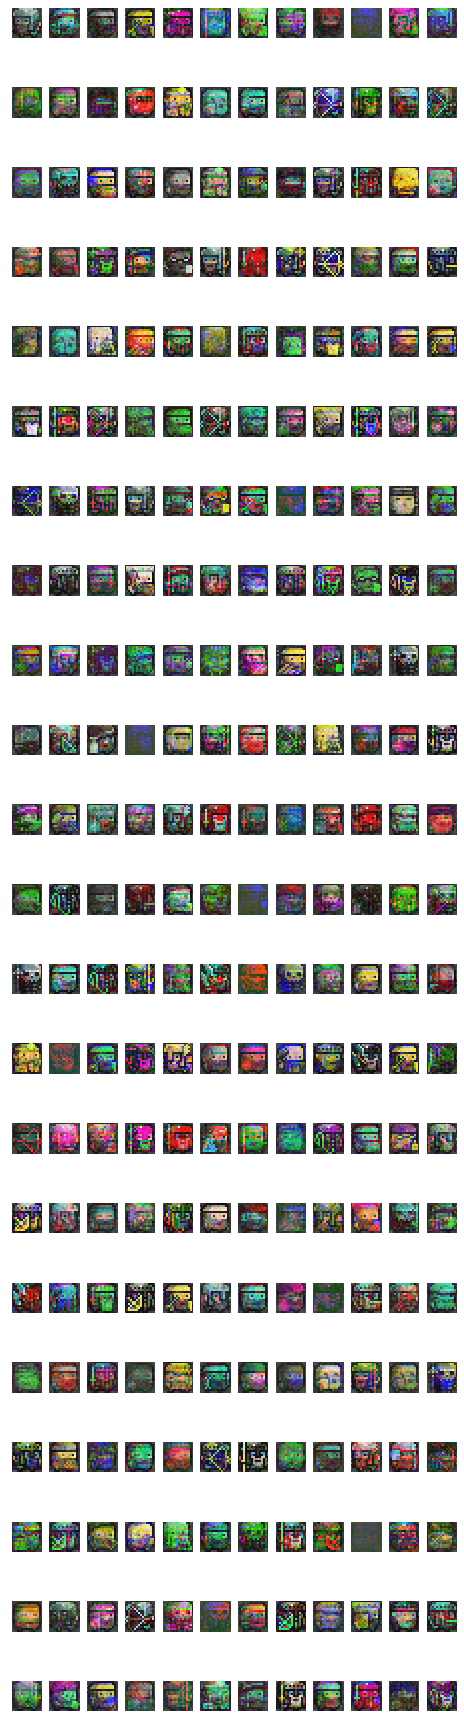

In [25]:
fig = plt.figure(figsize=(8, 32))
columns = 12
rows = 22

for i in range(1, columns*rows + 1):

    r = np.random.randint(0,227)
    g = np.random.randint(0,227)
    b = np.random.randint(0,227)

    x = np.random.randint(0,3)
    y = np.random.randint(0,3)
    z = np.random.randint(0,3)

    d = [np.asarray(trainX_r[r-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_g[g-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_b[b-1,:,:,:]).reshape([1,16,16,1])]

    img_r = autoencoder_r.predict(d[x])[0,:,:,0]
    img_g = autoencoder_g.predict(d[y])[0,:,:,0]
    img_b = autoencoder_b.predict(d[z])[0,:,:,0]
    img_rgb = np.dstack((img_r,img_g,img_b))
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_rgb)

plt.show()

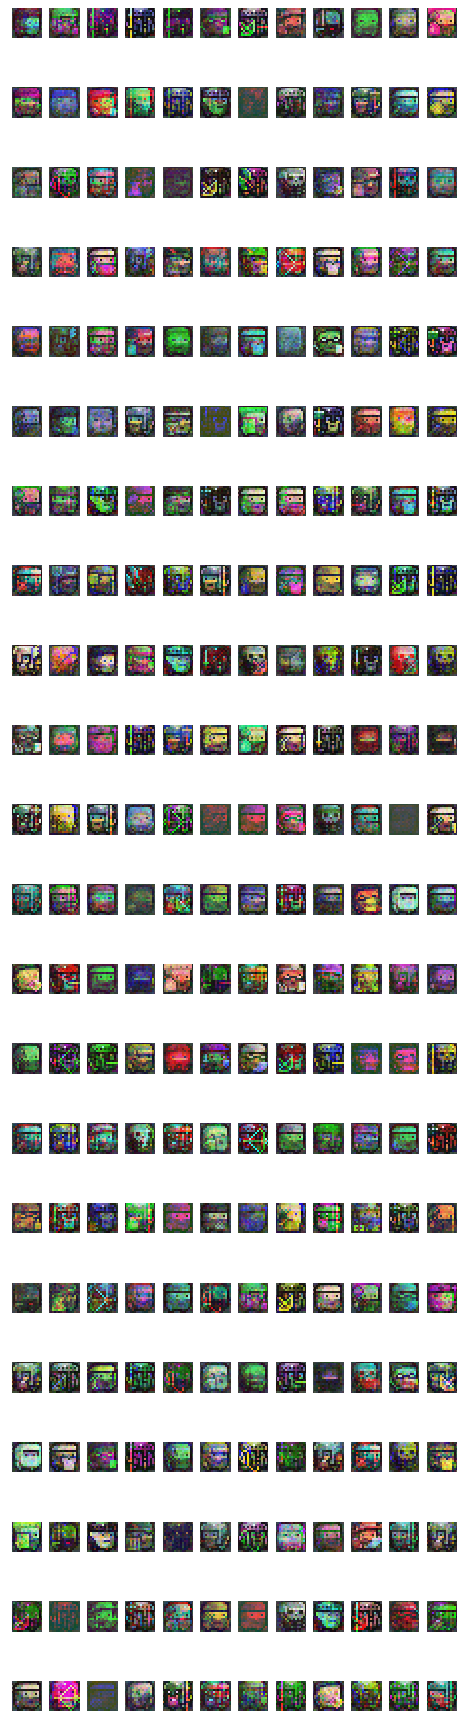

In [26]:
fig = plt.figure(figsize=(8, 32))
columns = 12
rows = 22

for i in range(1, columns*rows + 1):

    r = np.random.randint(0,227)
    #g = np.random.randint(0,227)
    #b = np.random.randint(0,227)

    x = np.random.randint(0,3)
    y = np.random.randint(0,3)
    z = np.random.randint(0,3)

    d = [np.asarray(trainX_r[r-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_g[r-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_b[r-1,:,:,:]).reshape([1,16,16,1])]

    img_r = autoencoder_r.predict(d[x])[0,:,:,0]
    img_g = autoencoder_g.predict(d[y])[0,:,:,0]
    img_b = autoencoder_b.predict(d[z])[0,:,:,0]
    img_rgb = np.dstack((img_r,img_g,img_b))
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_rgb)

plt.show()

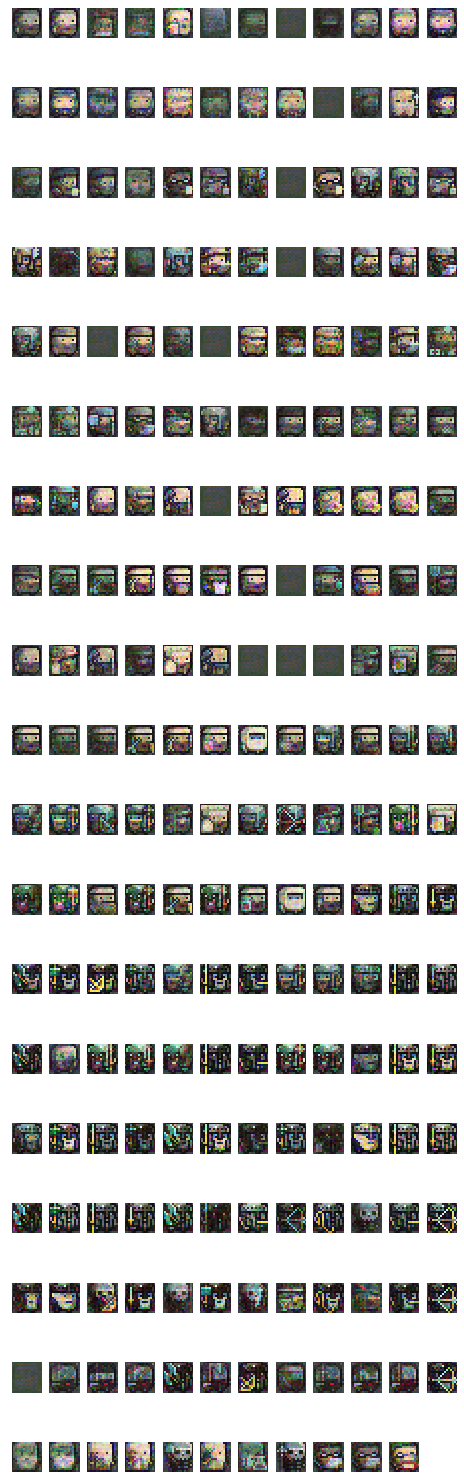

In [27]:
fig = plt.figure(figsize=(8, 32))
columns = 12
rows = 22

for i in range(1, 227 + 1):

    #r = np.random.randint(0,227)
    #g = np.random.randint(0,227)
    #b = np.random.randint(0,227)

    x = np.random.randint(0,3)
    #y = np.random.randint(0,3)
    #z = np.random.randint(0,3)

    d = [np.asarray(trainX_r[i-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_g[i-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_b[i-1,:,:,:]).reshape([1,16,16,1])]

    img_r = autoencoder_r.predict(d[x])[0,:,:,0]
    img_g = autoencoder_g.predict(d[x])[0,:,:,0]
    img_b = autoencoder_b.predict(d[x])[0,:,:,0]
    img_rgb = np.dstack((img_r,img_g,img_b))
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_rgb)

plt.show()

In [0]:
dwarves2 = imageio.imread('sprite.png')

In [0]:
tiles = np.expand_dims(dwarves2, axis=-1)
tiles = tiles.astype("float32") / 255.0
tiles_r = tiles[:,:, 0, :]
tiles_g = tiles[:,:, 1, :]
tiles_b = tiles[:,:, 2, :]

In [0]:
M = 16
N = 16

tiles_r = np.asarray(tiles_r)
tiles_g = np.asarray(tiles_g)
tiles_b = np.asarray(tiles_b)


tiles_r = [tiles_r[x:x+M,y:y+N] for x in range(0,tiles_r.shape[0],M) for y in range(0,tiles_r.shape[1],N)]
tiles_g = [tiles_g[x:x+M,y:y+N] for x in range(0,tiles_g.shape[0],M) for y in range(0,tiles_g.shape[1],N)]
tiles_b = [tiles_b[x:x+M,y:y+N] for x in range(0,tiles_b.shape[0],M) for y in range(0,tiles_b.shape[1],N)]

tiles_r = np.asarray(tiles_r)
tiles_g = np.asarray(tiles_g)
tiles_b = np.asarray(tiles_b)

In [0]:
trainX_r = tiles_r
trainX_g = tiles_g
trainX_b = tiles_b

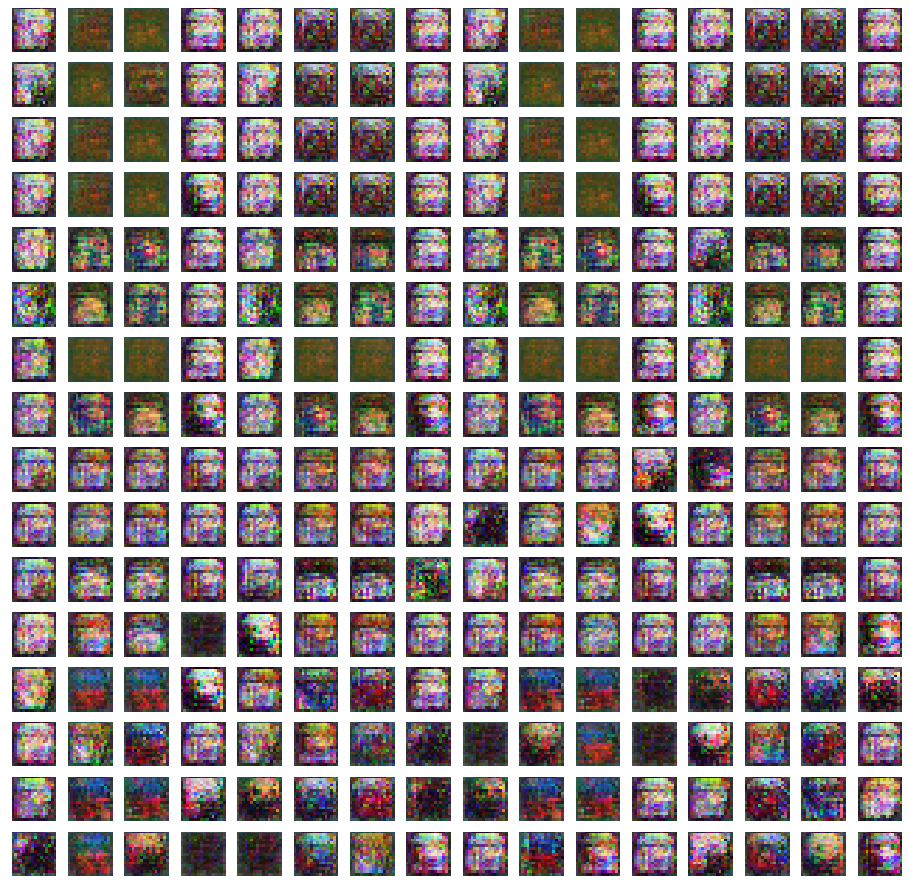

In [32]:
fig = plt.figure(figsize=(16, 16))
columns = 16
rows = 16

for i in range(1, columns*rows + 1):

    d = [np.asarray(trainX_r[i-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_g[i-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_b[i-1,:,:,:]).reshape([1,16,16,1])]

    img_r = autoencoder_r.predict(d[0])[0,:,:,0]
    img_g = autoencoder_g.predict(d[1])[0,:,:,0]
    img_b = autoencoder_b.predict(d[2])[0,:,:,0]
    img_rgb = np.dstack((img_r,img_g,img_b))
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_rgb)

plt.show()

([], <a list of 0 Text yticklabel objects>)

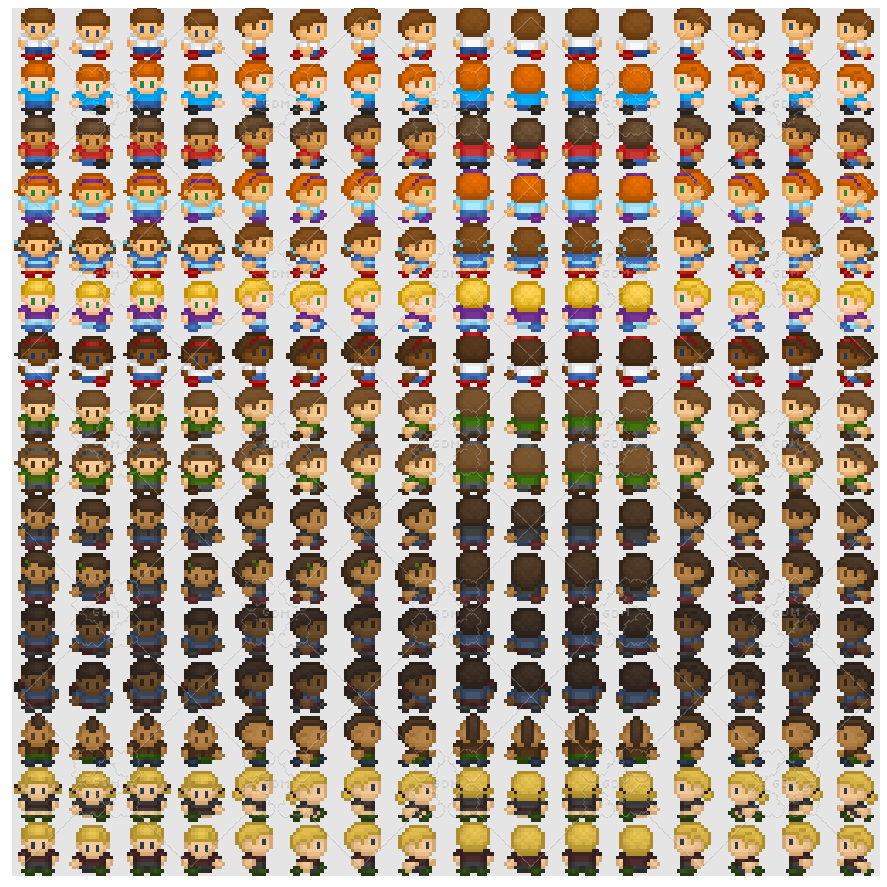

In [33]:
plt.figure(figsize=(16, 16))
plt.imshow(dwarves2)
plt.xticks([])
plt.yticks([])

In [0]:
dwarves = imageio.imread('dwarves.png')

In [35]:
dwarves.shape

(352, 192, 3)

In [0]:
tiles = np.expand_dims(dwarves, axis=-1)
tiles = tiles.astype("float32") / 255.0
tiles_r = tiles[:,:, 0, :]
tiles_g = tiles[:,:, 1, :]
tiles_b = tiles[:,:, 2, :]

In [0]:
M = 16
N = 16

tiles_r = np.asarray(tiles_r)
tiles_g = np.asarray(tiles_g)
tiles_b = np.asarray(tiles_b)


tiles_r = [tiles_r[x:x+M,y:y+N] for x in range(0,tiles_r.shape[0],M) for y in range(0,tiles_r.shape[1],N)]
tiles_g = [tiles_g[x:x+M,y:y+N] for x in range(0,tiles_g.shape[0],M) for y in range(0,tiles_g.shape[1],N)]
tiles_b = [tiles_b[x:x+M,y:y+N] for x in range(0,tiles_b.shape[0],M) for y in range(0,tiles_b.shape[1],N)]

tiles_r = np.asarray(tiles_r)
tiles_g = np.asarray(tiles_g)
tiles_b = np.asarray(tiles_b)

trainX_r = tiles_r[[np.var(x) > 0.01 for x in tiles_r]]
trainX_g = tiles_g[[np.var(x) > 0.01 for x in tiles_r]]
trainX_b = tiles_b[[np.var(x) > 0.01 for x in tiles_r]]


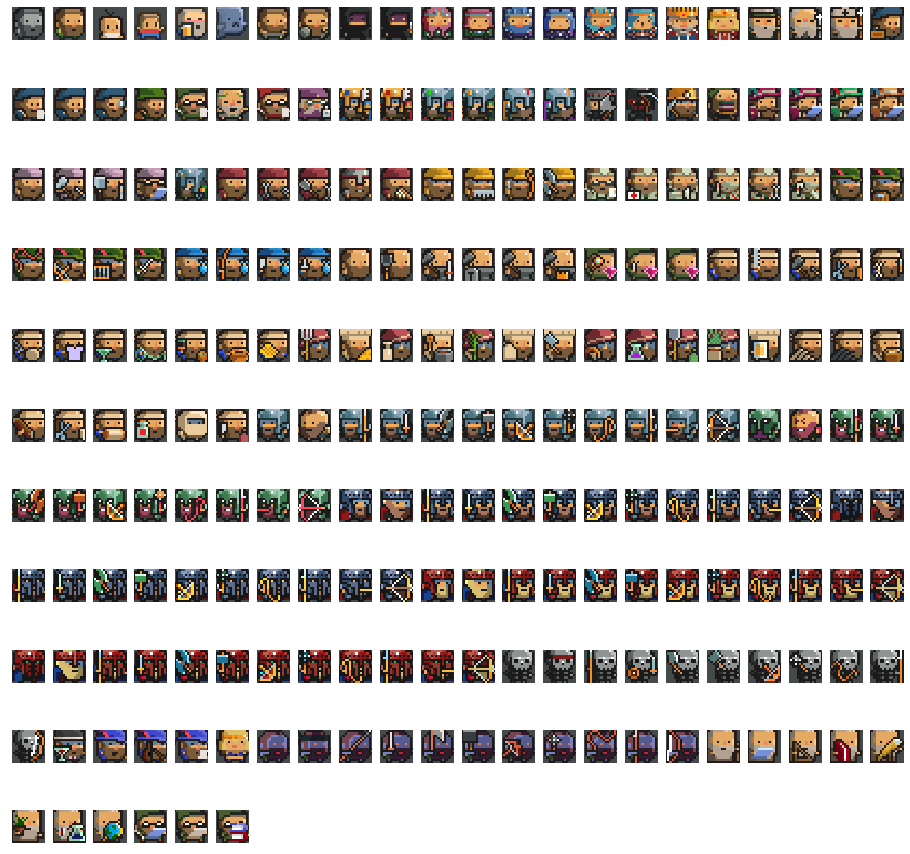

In [38]:
fig = plt.figure(figsize=(16, 16))
columns = 22
rows = 11

for i in range(1, 226 + 1):

    d = [np.asarray(trainX_r[i-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_g[i-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_b[i-1,:,:,:]).reshape([1,16,16,1])]

    img_r = d[0][0,:,:,0]
    img_g = d[1][0,:,:,0]
    img_b = d[2][0,:,:,0]
    img_rgb = np.dstack((img_r,img_g,img_b))
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_rgb)

plt.show()

In [39]:
trainX_r.shape

(226, 16, 16, 1)

In [40]:
trainX_g.shape

(226, 16, 16, 1)

In [41]:
trainX_b.shape

(226, 16, 16, 1)

In [42]:
EPOCHS = 25
BS = 8



# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder_r, decoder_r, autoencoder_r) = ConvAutoencoder.build(16, 16, 1)
opt = Adam(lr=1e-3)
autoencoder_r.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder_r.fit(
	trainX_r, trainX_r,
	epochs=EPOCHS,
	batch_size=BS)




# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder_g, decoder_g, autoencoder_g) = ConvAutoencoder.build(16, 16, 1)
opt = Adam(lr=1e-3)
autoencoder_g.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder_g.fit(
	trainX_g, trainX_g,
	epochs=EPOCHS,
	batch_size=BS)




# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder_b, decoder_b, autoencoder_b) = ConvAutoencoder.build(16, 16, 1)
opt = Adam(lr=1e-3)
autoencoder_b.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder_b.fit(
	trainX_b, trainX_b,
	epochs=EPOCHS,
	batch_size=BS)



[INFO] building autoencoder...
Train on 226 samples
Epoch 1/25
226/226 [==============================] - 3s 12ms/sample - loss: 0.0766
Epoch 2/25
226/226 [==============================] - 1s 2ms/sample - loss: 0.0500
Epoch 3/25
226/226 [==============================] - 1s 2ms/sample - loss: 0.0415
Epoch 4/25
226/226 [==============================] - 1s 2ms/sample - loss: 0.0351
Epoch 5/25
226/226 [==============================] - 1s 2ms/sample - loss: 0.0303
Epoch 6/25
226/226 [==============================] - 1s 2ms/sample - loss: 0.0268
Epoch 7/25
226/226 [==============================] - 1s 2ms/sample - loss: 0.0250
Epoch 8/25
226/226 [==============================] - 1s 2ms/sample - loss: 0.0238
Epoch 9/25
226/226 [==============================] - 1s 2ms/sample - loss: 0.0214
Epoch 10/25
226/226 [==============================] - 1s 2ms/sample - loss: 0.0199
Epoch 11/25
226/226 [==============================] - 1s 2ms/sample - loss: 0.0194
Epoch 12/25
226/226 [===========

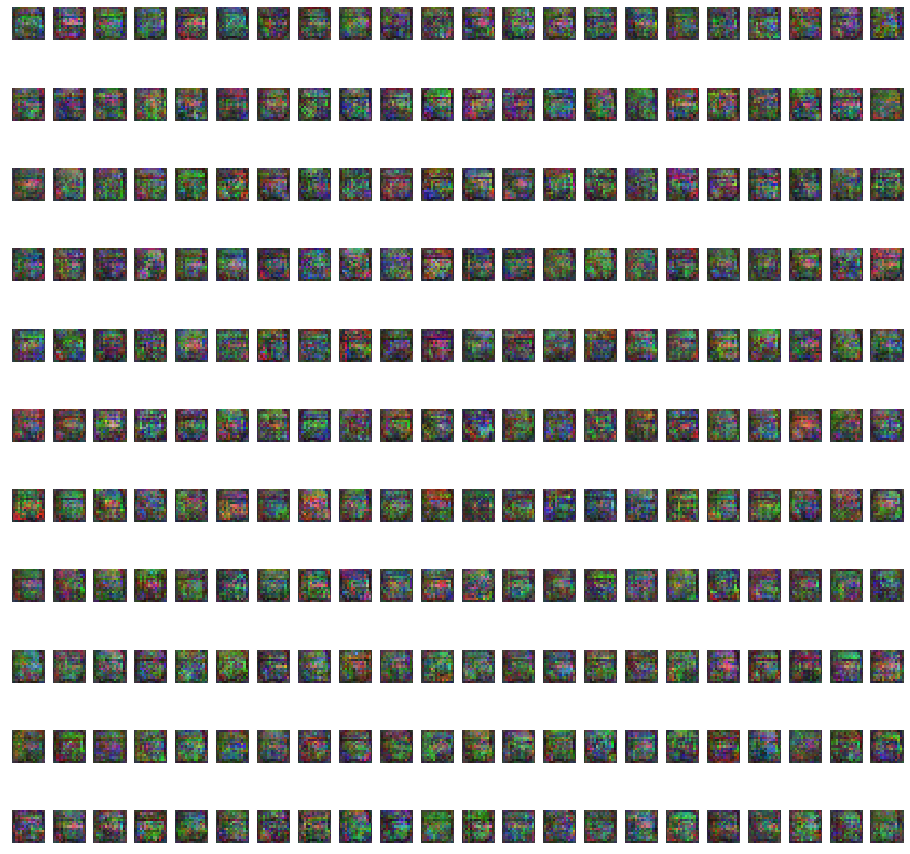

In [43]:
fig=plt.figure(figsize=(16, 16))
columns = 22
rows = 11
for i in range(1, columns*rows + 1):
    img_r = autoencoder_r.predict(np.asarray(np.random.random(16*16).reshape([1,16,16,1])))[0,:,:,0]
    img_g = autoencoder_g.predict(np.asarray(np.random.random(16*16).reshape([1,16,16,1])))[0,:,:,0]
    img_b = autoencoder_b.predict(np.asarray(np.random.random(16*16).reshape([1,16,16,1])))[0,:,:,0]
    img_rgb = np.dstack((img_r,img_g,img_b))
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_rgb)
plt.show()

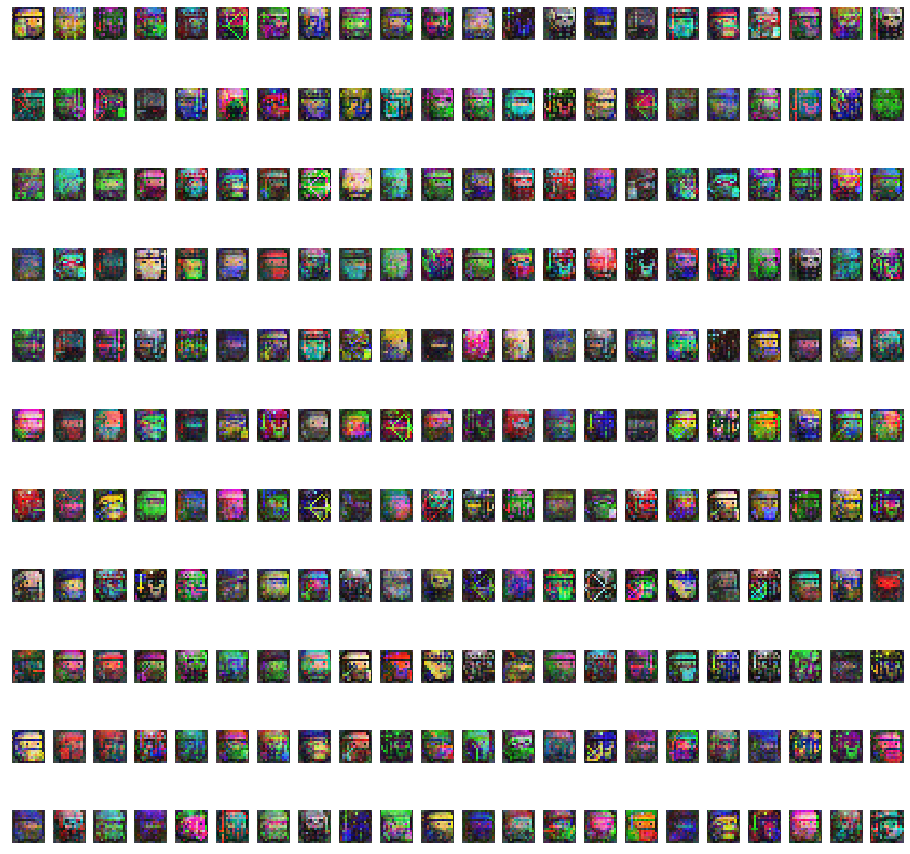

In [44]:
fig = plt.figure(figsize=(16, 16))
columns = 22
rows = 11

for i in range(1, columns*rows + 1):

    r = np.random.randint(0,227)
    g = np.random.randint(0,227)
    b = np.random.randint(0,227)

    x = np.random.randint(0,3)
    y = np.random.randint(0,3)
    z = np.random.randint(0,3)

    d = [np.asarray(trainX_r[r-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_g[g-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_b[b-1,:,:,:]).reshape([1,16,16,1])]

    img_r = autoencoder_r.predict(d[x])[0,:,:,0]
    img_g = autoencoder_g.predict(d[y])[0,:,:,0]
    img_b = autoencoder_b.predict(d[z])[0,:,:,0]
    img_rgb = np.dstack((img_r,img_g,img_b))
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_rgb)

plt.show()

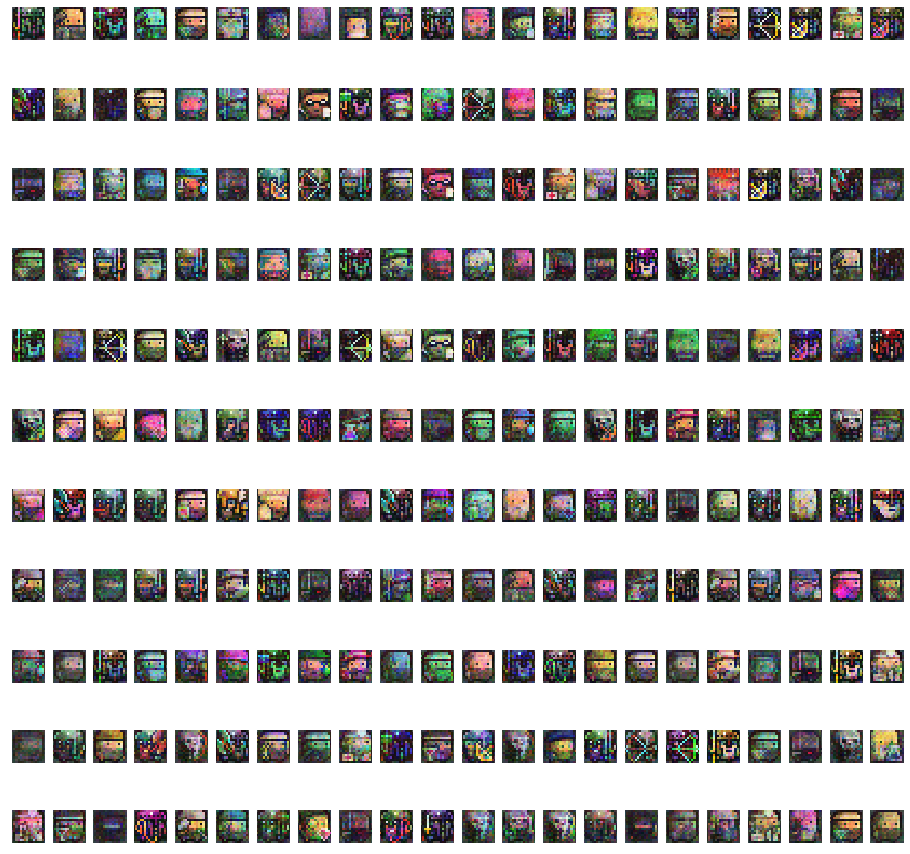

In [45]:
fig = plt.figure(figsize=(16, 16))
columns = 22
rows = 11

for i in range(1, columns*rows + 1):

    r = np.random.randint(0,227)
    #g = np.random.randint(0,227)
    #b = np.random.randint(0,227)

    x = np.random.randint(0,3)
    y = np.random.randint(0,3)
    z = np.random.randint(0,3)

    d = [np.asarray(trainX_r[r-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_g[r-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_b[r-1,:,:,:]).reshape([1,16,16,1])]

    img_r = autoencoder_r.predict(d[x])[0,:,:,0]
    img_g = autoencoder_g.predict(d[y])[0,:,:,0]
    img_b = autoencoder_b.predict(d[z])[0,:,:,0]
    img_rgb = np.dstack((img_r,img_g,img_b))
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_rgb)

plt.show()

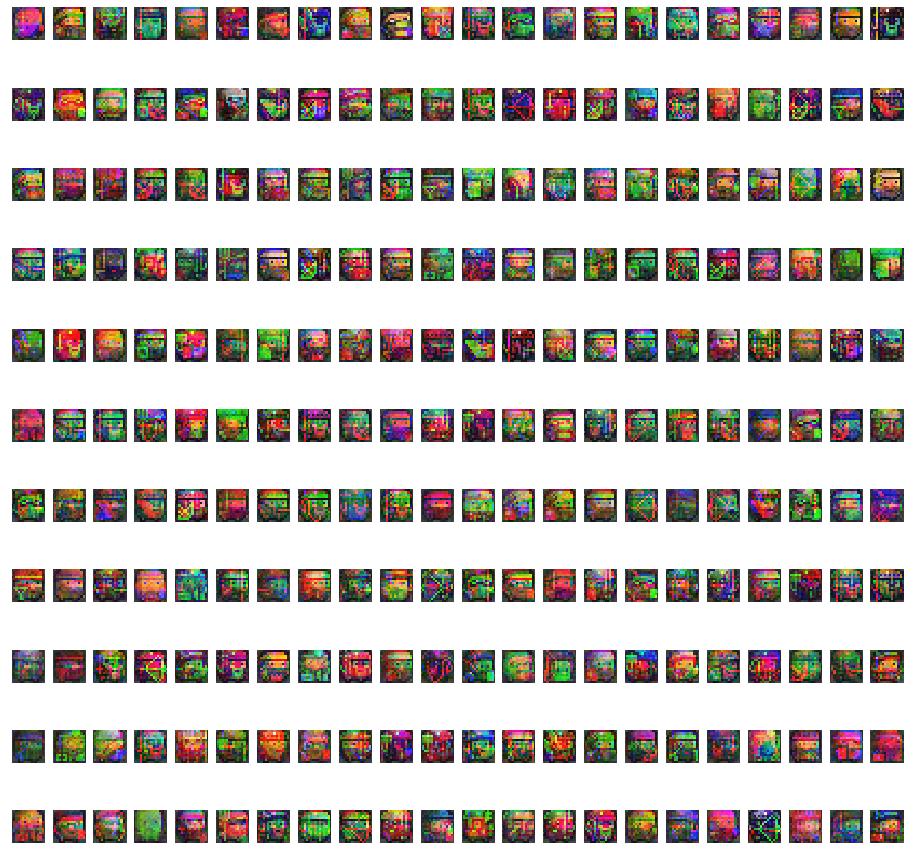

In [46]:
fig = plt.figure(figsize=(16, 16))
columns = 22
rows = 11

for i in range(1, columns*rows + 1):

    r = np.random.randint(0,227)
    g = np.random.randint(0,227)
    b = np.random.randint(0,227)

    #x = np.random.randint(0,3)
    #y = np.random.randint(0,3)
    #z = np.random.randint(0,3)

    d = [np.asarray(trainX_r[r-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_g[g-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_b[b-1,:,:,:]).reshape([1,16,16,1])]

    img_r = autoencoder_r.predict(d[0])[0,:,:,0]
    img_g = autoencoder_g.predict(d[1])[0,:,:,0]
    img_b = autoencoder_b.predict(d[2])[0,:,:,0]
    img_rgb = np.dstack((img_r,img_g,img_b))
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_rgb)

plt.show()

In [47]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np

Using TensorFlow backend.


In [0]:
class GAN():
  def __init__(self):
    self.img_rows = 16
    self.img_cols = 16
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 100
    optimizer = Adam(0.0002, 0.5)
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy',
                               optimizer=optimizer,
                               metrics=['accuracy'])
    self.generator = self.build_generator()
    z = Input(shape=(self.latent_dim,))
    img = self.generator(z)
    self.discriminator.trainable = False
    validity = self.discriminator(img)
    self.combined = Model(z, validity)
    self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

  def build_generator(self):
    model = Sequential()
    model.add(Dense(256, input_dim=self.latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(self.img_shape), activation='tanh'))
    model.add(Reshape(self.img_shape))
    model.summary()
    noise = Input(shape=(self.latent_dim,))
    img = model(noise)
    return Model(noise, img)

  def build_discriminator(self):
    model = Sequential()
    model.add(Flatten(input_shape=self.img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    img = Input(shape=self.img_shape)
    validity = model(img)
    return Model(img, validity)

  def sample_images(self, epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, self.latent_dim))
    gen_imgs = self.generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
      for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
    fig.savefig("%d.png" % epoch)
    plt.close()


  def train(self, epochs, batch_size=128, sample_interval=50):
    #(X_train, _), (_, _) = mnist.load_data()    
    X_train = tiles
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      imgs = X_train[idx]
      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
      gen_imgs = self.generator.predict(noise)
      d_loss_real = self.discriminator.train_on_batch(imgs, valid)
      d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
      g_loss = self.combined.train_on_batch(noise, valid)
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
      if epoch % sample_interval == 0:
        self.sample_images(epoch)


In [0]:
dwarves = imageio.imread('dwarves.png')
dwarves = cv2.cvtColor(dwarves, cv2.COLOR_BGR2GRAY)

In [50]:
dwarves.shape

(352, 192)

In [63]:
M = 16
N = 16

tiles = dwarves

tiles = [tiles[x:x+M,y:y+N] for x in range(0,tiles.shape[0],M) for y in range(0,tiles.shape[1],N)]

tiles = np.asarray(tiles)

tiles = tiles[[np.var(x) > 0 for x in tiles]]
tiles.shape

(227, 16, 16)

In [0]:
gan = GAN()
gan.train(epochs=10000, batch_size=132, sample_interval=100)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 257       
Total params: 263,169
Trainable params: 263,169
Non-trainable params: 0
________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'



0 [D loss: 0.563733, acc.: 86.74%] [G loss: 0.604393]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.578875, acc.: 59.09%] [G loss: 0.649752]
2 [D loss: 0.484030, acc.: 70.08%] [G loss: 0.734181]
3 [D loss: 0.417904, acc.: 78.41%] [G loss: 0.879864]
4 [D loss: 0.360009, acc.: 89.02%] [G loss: 0.969087]
5 [D loss: 0.320658, acc.: 91.29%] [G loss: 1.096438]
6 [D loss: 0.263813, acc.: 98.11%] [G loss: 1.202732]
7 [D loss: 0.244972, acc.: 97.73%] [G loss: 1.332296]
8 [D loss: 0.215733, acc.: 100.00%] [G loss: 1.400529]
9 [D loss: 0.194294, acc.: 99.62%] [G loss: 1.463970]
10 [D loss: 0.179329, acc.: 99.62%] [G loss: 1.574268]
11 [D loss: 0.182934, acc.: 99.62%] [G loss: 1.686684]
12 [D loss: 0.149815, acc.: 99.24%] [G loss: 1.750601]
13 [D loss: 0.134334, acc.: 100.00%] [G loss: 1.830868]
14 [D loss: 0.127547, acc.: 99.62%] [G loss: 1.961316]
15 [D loss: 0.117652, acc.: 100.00%] [G loss: 2.012781]
16 [D loss: 0.104276, acc.: 100.00%] [G loss: 2.081360]
17 [D loss: 0.103243, acc.: 99.62%] [G loss: 2.112210]
18 [D loss: 0.100783, acc.: 100.00%] [G loss: 2.193861]
19 [D loss: 0.